# MUVA 2022/23 - Imagen Médica
## Práctica 2: Registro de Imágenes Médicas
### Grupo 4: Pablo Ríos y Celia García

# 2. Implementación de un algoritmo de registro

El objetivo de este apartado es implementar en Python un algoritmo de registro
rígido.

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

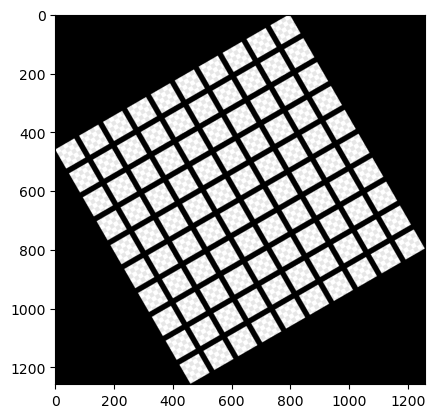

In [12]:
img = cv2.imread('material/cuadricula_rotada.png', cv2.IMREAD_GRAYSCALE) / 255.

plt.imshow(img, cmap='gray')

### 2.1 Transformación: Crear una función que aplique una transformación rígida a una imagen con los parámetros que se le pasan como entrada.

In [13]:
def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    """
    Rotates an image (angle in degrees)
    :param image (np.ndarray): Image to be rotated
    :param angle (float): Angle of rotation in degrees
    :return (np.ndarray): Rotated image
    """

    theta = np.deg2rad(angle)

    h, w = image.shape[:2]

    T = np.array([[1, 0, -w/2],
                  [0, 1, -h/2],
                  [0, 0, 1]])

    M = np.array([[np.cos(theta), -np.sin(theta), 0],
                  [np.sin(theta), np.cos(theta), 0],
                  [0, 0, 1]])

    M_prime = np.linalg.inv(T) @ M @ T

    rotated = np.zeros_like(image)
    for i in range(h):
        for j in range(w):
            p = np.array([j, i, 1])
            q = M_prime @ p
            x, y = q[:2]
            if 0 <= x < w and 0 <= y < h:
                rotated[int(y), int(x)] = image[i, j]

    return rotated

Conociendo que se ha aplicado una rotación de 30º, podemos comprobar que la función funciona correctamente.

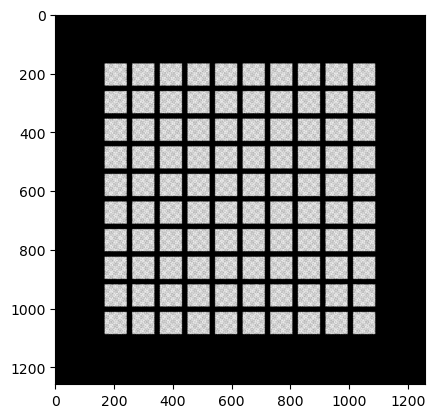

In [14]:
rotated_img = rotate_image(img, 30)
plt.imshow(rotated_img, cmap='gray')

### 2.2 Interpolación: Crear una función que interpole la imagen transformada, usando interpolación trilineal.